# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [11]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [12]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:            # clear_output(wait=True)

        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [13]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder


/content/mit_semseg/models/models.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(weights, map_location=lambda storage, loc: storage), strict=False)


Loading weights for net_decoder


/content/mit_semseg/models/models.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(weights, map_location=lambda storage, loc: storage), strict=False)


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [14]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

In [ ]:
singleton_batch['img_data'].shape


torch.Size([1, 3, 512, 768])

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

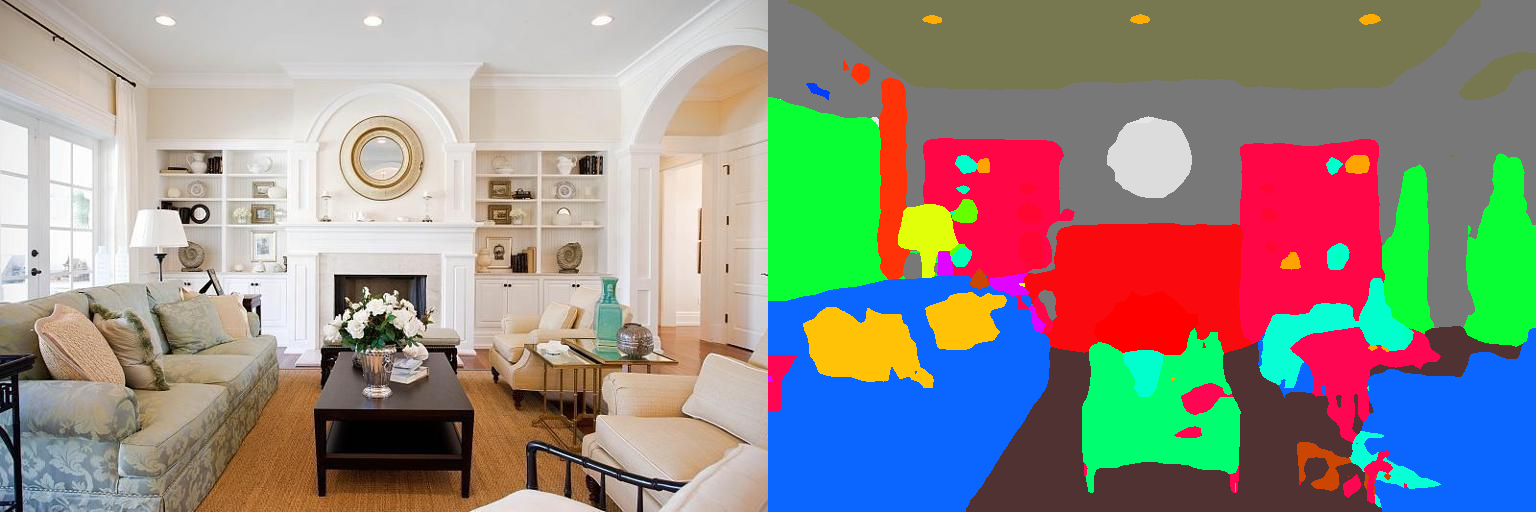

In [15]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [ ]:
# # Top classes in answer
# predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
# for c in predicted_classes[:15]:
#     visualize_result(img_original, pred, c)

In [ ]:
# Step 1: Import required libraries
import cv2
import torch
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
import base64
import time
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.measure import regionprops
import matplotlib.patches as patches


def compute_change(prev_image, image, threshold=100):
    a = prev_image.mean(axis=-1)
    b = image.mean(axis=-1)
    m = np.abs(a - b)
    # print(m.min(), m.max())
    m = m > threshold

    return m


def get_bounding_box(change_map):
    labels = measure.label(change_map, connectivity=2)

    regions = regionprops(labels)
    bounding_boxes = [region.bbox for region in regions if region.area > 500]  # Filter out small regions

    expanded_boxes = []
    for box in bounding_boxes:
        minr, minc, maxr, maxc = box
        expanded_box = (max(0, minr - 3), max(0, minc - 3),
                        min(change_map.shape[0], maxr + 3),
                        min(change_map.shape[1], maxc + 3))
        expanded_boxes.append(expanded_box)

    return expanded_boxes


def capture_frame():
    js = Javascript('''
        async function captureFrame() {
            const video = document.createElement('video');
            video.width = 512;  // Adjust dimensions as needed
            video.height = 768; // Adjust dimensions as needed
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the canvas to match the video dimensions
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getVideoTracks()[0].stop(); // Stop the video stream after capturing the frame
            return canvas.toDataURL('image/jpeg', 0.8); // Return the image as a data URL
        }
    ''')
    display(js)
    data = eval_js('captureFrame()')
    return data


def preprocess_frame(frame, output_size=(512, 768)):
    # Resize and preprocess the frame
    resized_frame = cv2.resize(frame, (output_size[1], output_size[0]))
    resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    normalized_frame = resized_frame.astype(np.float32) / 255.0
    normalized_frame = normalized_frame.transpose(2, 0, 1)
    img_tensor = torch.tensor(normalized_frame).unsqueeze(0)
    return img_tensor


def continuous_segmentation(segmentation_module, output_size=(512, 768), output_file='output_video.avi'):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI
    out = cv2.VideoWriter(output_file, fourcc, 20.0, (output_size[1], output_size[0] * 2))  # Two stacked frames

    frame_count = 0
    total_time = 0.0  # Variable to accumulate processing time

    prev_scores = None  # Variable to store the previous segmentation mask
    prev_img = None

    try:
        while True:
            data = capture_frame()

            binary = data.split(',')[1]
            img = np.frombuffer(base64.b64decode(binary), dtype=np.uint8)
            img = cv2.imdecode(img, cv2.IMREAD_COLOR)
            # print(img.max(), img.min())


            change_map = compute_change(prev_img, img) if prev_img is not None else torch.ones(img.shape[:2])*255
            dilated_map = morphology.dilation(change_map, morphology.square(20))  # Use a disk-shaped structuring element


            singleton_batch = {'img_data': preprocess_frame(img, output_size=output_size).cuda()}
            # print(singleton_batch['img_data'].shape)


            start_time = time.time()

            expanded_boxes = get_bounding_box(dilated_map)
            for box in expanded_boxes: #[:1]:
                min_row, min_col, max_row, max_col = box
                with torch.no_grad():

                      tmp_singleton_batch = singleton_batch.copy()
                      tmp_singleton_batch['img_data'] = singleton_batch['img_data'][:,:,min_row:max_row,min_col:max_col]
                      new_scores = segmentation_module(tmp_singleton_batch, segSize=(max_row-min_row,max_col-min_col)) # only the changed region
                      scores[:,:,min_row:max_row,min_col:max_col] = new_scores

            prev_img = img
            prev_scores = scores
            predicted_classes = torch.argmax(scores, dim=1).squeeze().cpu().numpy()
            segmentation_mask = cv2.applyColorMap(predicted_classes.astype(np.uint8), cv2.COLORMAP_JET)

            # img_resized = cv2.resize(img, (output_size[1], output_size[0]))
            # combined_frame = np.vstack((img_resized, segmentation_mask))
            # # Write the combined frame to the video file
            # # out.write(combined_frame)
            # # Clear the output and display the combined frame
            # # clear_output(wait=True)
            # # cv2_imshow(combined_frame)


            plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
            segmentation_mask = cv2.resize(segmentation_mask, (640, 480))
            plt.imshow(segmentation_mask); plt.xticks([]); plt.yticks([]); plt.show()

            # fig, ax = plt.subplots(figsize=(6.5, 6.5))
            # ax.imshow(dilated_map, cmap='gray')
            # ax.set_xticks([])
            # ax.set_yticks([])
            # for box in expanded_boxes:
            #     minr, minc, maxr, maxc = box
            #     rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
            #                         edgecolor='red', facecolor='none', linewidth=2)
            #     ax.add_patch(rect)
            # plt.show()


            # print(img.shape, segmentation_mask.shape, dilated_map.shape)


            end_time = time.time()
            processing_time = end_time - start_time
            total_time += processing_time
            frame_count += 1


            # Calculate and display FPS every 10 frames
            if frame_count % 10 == 0:
                fps = frame_count / total_time
                print(f"Processed {frame_count} frames - Average FPS: {fps:.2f}")

            # Add delay between frames to control the capture rate
            # time.sleep(0.1)  # Adjust this delay as needed

    except KeyboardInterrupt:
        print("Stream stopped.")
    finally:
        # Release the video writer
        out.release()
        print(f"Video saved as {output_file}.")


def continuous_segmentation_allframes(segmentation_module, output_size=(512, 768), output_file='output_video.avi'):
    # Set up video writer to save the video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI
    out = cv2.VideoWriter(output_file, fourcc, 20.0, (output_size[1], output_size[0] * 2))  # Two stacked frames

    frame_count = 0
    total_time = 0.0  # Variable to accumulate processing time


    try:
        while True:
            data = capture_frame()

            binary = data.split(',')[1]
            img = np.frombuffer(base64.b64decode(binary), dtype=np.uint8)
            img = cv2.imdecode(img, cv2.IMREAD_COLOR)

            singleton_batch = {'img_data': preprocess_frame(img, output_size=output_size).cuda()}


            start_time = time.time()
            with torch.no_grad():
                scores = segmentation_module(singleton_batch, segSize=output_size)

            predicted_classes = torch.argmax(scores, dim=1).squeeze().cpu().numpy()

            segmentation_mask = cv2.applyColorMap(predicted_classes.astype(np.uint8), cv2.COLORMAP_JET)

            # img_resized = cv2.resize(img, (output_size[1], output_size[0]))
            # combined_frame = np.vstack((img_resized, segmentation_mask))

            plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
            segmentation_mask = cv2.resize(segmentation_mask, (640, 480))
            plt.imshow(segmentation_mask); plt.xticks([]); plt.yticks([]); plt.show()

            end_time = time.time()


            processing_time = end_time - start_time
            total_time += processing_time
            frame_count += 1

            if frame_count % 10 == 0:
                fps = frame_count / total_time
                print(f"Processed {frame_count} frames - Average FPS: {fps:.2f}")

            # Add delay between frames to control the capture rate
            # time.sleep(0.1)  # Adjust this delay as needed

    except KeyboardInterrupt:
        print("Stream stopped.")
    finally:
        # Release the video writer
        out.release()
        print(f"Video saved as {output_file}.")

# Replace `segmentation_module` with your pre-trained model here
# Call the continuous_segmentation function to start
# continuous_segmentation(segmentation_module)
continuous_segmentation_allframes(segmentation_module)


In [30]:
!ls -al


total 1116
drwxr-xr-x 1 root root   4096 Oct 26 03:05 .
drwxr-xr-x 1 root root   4096 Oct 26 02:47 ..
-rw-r--r-- 1 root root  62271 Jun 18  2016 ADE_val_00001519.jpg
drwxr-xr-x 3 root root   4096 Oct 26 02:51 ckpt
drwxr-xr-x 4 root root   4096 Oct 24 13:20 .config
drwxr-xr-x 2 root root   4096 Oct 26 02:51 config
drwxr-xr-x 2 root root   4096 Oct 26 02:51 data
-rwxr-xr-x 1 root root    910 Oct 26 02:51 demo_test.sh
-rwxr-xr-x 1 root root    221 Oct 26 02:51 download_ADE20K.sh
-rw-r--r-- 1 root root   7059 Oct 26 02:51 eval_multipro.py
-rw-r--r-- 1 root root   5992 Oct 26 02:51 eval.py
drwxr-xr-x 8 root root   4096 Oct 26 04:09 .git
-rw-r--r-- 1 root root     27 Oct 26 02:51 .gitattributes
-rw-r--r-- 1 root root     90 Oct 26 02:51 .gitignore
-rw-r--r-- 1 root root 934462 Oct 26 04:10 install.log
-rw-r--r-- 1 root root   1525 Oct 26 02:51 LICENSE
drwxr-xr-x 6 root root   4096 Oct 26 02:53 mit_semseg
drwxr-xr-x 2 root root   4096 Oct 26 02:51 notebooks
-rw-r--r-- 1 root root   5686 Oct 2

In [26]:
from IPython.display import HTML

def play_video_with_html5(video_file):
    # Display the video using HTML5
    return HTML(f'''
    <video width="640" height="480" controls>
        <source src="{video_file}" type="video/avi">
        Your browser does not support the video tag.
    </video>
    ''')

# Display the video
play_video_with_html5('output_video.avi')

In [ ]:
from google.colab import files
files.download('output_video.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>